In [1]:
! nvidia-smi

Mon Nov  9 13:40:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    66W /  70W |  14314MiB / 15109MiB |     99%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:00:05.0 Off |                    0 |
| N/A   80C    P0    64W /  70W |  14314MiB / 15109MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import os
import pandas as pd
import numpy as np 
import random

from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras import backend as K
from transformers import AutoTokenizer, TFAutoModel

# from data.datasets import regular_encode, data_generator
from data.tokenizer import VnCoreTokenizer
# from trainer.model import build_model
# from utils import *

from tqdm.notebook import tqdm
tqdm.pandas()

/home/leonard/leonard/ai_server_1_anaconda3/envs/tf230/lib/python3.7/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
def seed_all(seed=1512):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [4]:
SEED = 1710
MAX_LEN = 296
N_HIDDENS = 3
BATCH_SIZE = 64
N_SPLITS = 5
N_EPOCHS = 5
DISPLAY = 1  # USE display=1 FOR INTERACTIVE

seed_all(SEED)

In [8]:
# vncore_tokenizer = VnCoreTokenizer()
# warmup_train_df = pd.read_excel("../data/raw_data/warmup_training_dataset.xlsx", index_col="id")
# warmup_test_df = pd.read_excel("../data/raw_data/warmup_test_set.xlsx", index_col="id")

# public_train_df = pd.read_csv("../data/raw_data/public_train.csv")
# public_test_df = pd.read_csv("../data/raw_data/public_test.csv")

# TODO: make use of warmup_test_df
# train_df = pd.concat([warmup_train_df, public_train_df]).drop_duplicates()
# test_df = public_test_df.copy()
# train_df["post_message"].fillna("", inplace=True)

# train_df["post_message"] = train_df["post_message"].progress_apply(vncore_tokenizer.tokenize)
# test_df["post_message"] = test_df["post_message"].progress_apply(vncore_tokenizer.tokenize)

# os.makedirs("../data/tokenized_data/", exist_ok=True)
# train_df.to_csv("../data/tokenized_data/train.csv", index=False)
# test_df.to_csv("../data/tokenized_data/test.csv", index=False)

# train_df = pd.read_csv("../data/train_5_folds.csv")
# train_df["post_message"] = train_df["post_message"].astype(str)
# train_df["post_message"] = train_df["post_message"].progress_apply(vncore_tokenizer.tokenize)
# train_df.to_csv("../data/tokenized_data/train_5_folds.csv", index=False)

In [6]:
# %%time

train_df = pd.read_csv("../data/tokenized_data/train_5_folds.csv")
test_df = pd.read_csv("../data/tokenized_data/test.csv")

train_df["post_message"] = train_df["post_message"].astype(str)
test_df["post_message"] = test_df["post_message"].astype(str)

In [7]:
# train_len_word = [len(text.split()) for text in train_df.post_message]
# test_len_word = [len(text.split()) for text in test_df.post_message]
# test_len_char = [len(text) for text in train_df.post_message]
# test_len_char = [len(text) for text in test_df.post_message]

In [8]:

AUTO = tf.data.experimental.AUTOTUNE


def regular_encode(texts, bert_tokenizer, max_len=256):

    bert_enc_di = bert_tokenizer.batch_encode_plus(
        texts,
        return_token_type_ids=True,
        pad_to_max_length=True,
        max_length=max_len,
        truncation=True,
    )

    bert_enc = (
        np.array(bert_enc_di["input_ids"]),
        np.array(bert_enc_di["attention_mask"]),
        np.array(bert_enc_di["token_type_ids"]),
    )
    return bert_enc


def data_generator(train_df, val_df, bert_tokenizer, max_len, batch_size=32):

    X_train = regular_encode(train_df["post_message"].values, bert_tokenizer, max_len)
    # y_train = tf.keras.utils.to_categorical(train_df['Label'].values, num_classes=2)
    y_train = train_df["label"].values
    X_val = regular_encode(val_df["post_message"].values, bert_tokenizer, max_len)
    # y_val = tf.keras.utils.to_categorical(val_df['Label'].values, num_classes=2)
    y_val = val_df["label"].values

    train_dataset = (
        tf.data.Dataset.from_tensor_slices((X_train, y_train))
        .repeat()
        .shuffle(1024)
        .batch(batch_size)
        .prefetch(AUTO)
    )

    valid_dataset = (
        tf.data.Dataset.from_tensor_slices((X_val, y_val))
        .batch(batch_size)
        .cache()
        .prefetch(AUTO)
    )

    return train_dataset, valid_dataset

In [9]:
def build_model(bert_model_name_or_path="vinai/phobert-base", max_len=384, n_hiddens=4):
    bert_model = TFAutoModel.from_pretrained(bert_model_name_or_path)

    bert_input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="bert_input_id"
    )
    bert_attention_mask = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="bert_attention_mask"
    )
    bert_token_type_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="bert_token_type_ids"
    )

    bert_sequence_output = bert_model(
        bert_input_word_ids,
        attention_mask=bert_attention_mask,
        token_type_ids=bert_token_type_ids,
        output_hidden_states=True,
        output_attentions=True,
        
    )

    # print(len(bert_sequence_output)) # 4

    # print(bert_sequence_output[0].shape) # (None, max_len, 768)

    # print(bert_sequence_output[1].shape) # (None, 768)
    # print(len(bert_sequence_output[2])) # 13
    # print(bert_sequence_output[2][0].shape) # (None, max_len, 768)
    # print(len(bert_sequence_output[3])) # 12
    # print(bert_sequence_output[3][0].shape) # (None, 12, None, max_len)

    # TODO: get bert embedding

    if n_hiddens == -1:  # get [CLS] token embedding only
        # print("Get pooler output of shape (batch_size, hidden_size)")
        bert_sequence_output = bert_sequence_output[0][:, 0, :]
    else:  # concatenate n_hiddens final layer
        # print(f"Concatenate {n_hiddens} hidden_states of shape (batch_size, hidden_size)")
        bert_sequence_output = tf.concat(
            [bert_sequence_output[2][-i] for i in range(n_hiddens)], axis=-1)

    # print("bert_sequence_output shape", bert_sequence_output.shape)

    
    
    out = tf.keras.layers.Flatten()(bert_sequence_output)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(out)

    model = tf.keras.models.Model(
        inputs=[
            bert_input_word_ids,
            bert_attention_mask,
            bert_token_type_ids,  # bert input
        ],
        outputs=out,
    )
    model.compile(
        tf.keras.optimizers.Adam(lr=5e-5),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC()],
    )

    return model

In [10]:
bert = "/home/leonard/leonard/vlsp/ReINTEL/pretrained_phobert-base"
# bert = 'vinai/phobert-base'

model = build_model(bert, max_len=MAX_LEN, n_hiddens=N_HIDDENS)
bert_tokenizer = AutoTokenizer.from_pretrained(bert)

model.summary()
exp = f'phobert_{MAX_LEN}_len_{N_SPLITS}_folds_{N_HIDDENS}_hidden_states'

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
output_dir = f'../outputs/{exp}_models'
os.makedirs(output_dir, exist_ok=True)

Some layers from the model checkpoint at /home/leonard/leonard/vlsp/ReINTEL/pretrained_phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at /home/leonard/leonard/vlsp/ReINTEL/pretrained_phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word e

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_input_id (InputLayer)      [(None, 296)]        0                                            
__________________________________________________________________________________________________
bert_attention_mask (InputLayer [(None, 296)]        0                                            
__________________________________________________________________________________________________
bert_token_type_ids (InputLayer [(None, 296)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode ((None, 296, 768), ( 134998272   bert_input_id[0][0]              
                                                                 bert_attention_mask[0]

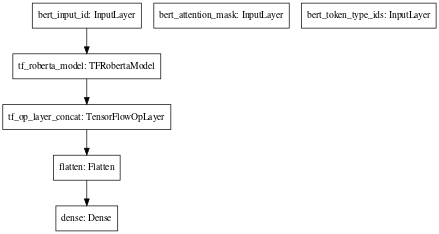

In [11]:
tf.keras.utils.plot_model(model,
                        #   show_shapes=False,
                        #   show_layer_names=True,
                        #   rankdir='TB', 
                        #   expand_nested=False,
                          dpi=50
                          )

In [12]:
def scheduler(epoch):
    return 3e-5*0.2**epoch

In [13]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


In [14]:
# for fold, (idxT, idxV) in enumerate(kf.split(train_df)):
for fold in sorted(train_df["fold"].unique()):
    print('*'*100)
    print(f'FOLD: {fold+1}/{N_SPLITS}')
    
    K.clear_session()
    with strategy.scope():
        model = build_model(bert, max_len=MAX_LEN, n_hiddens=N_HIDDENS)

    reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

    model_dir = os.path.join(output_dir, f'Fold_{fold+1}_{SEED}.h5')

    sv = tf.keras.callbacks.ModelCheckpoint(model_dir,
                                            monitor='val_auc',
                                            verbose=1,
                                            save_best_only=True,
                                            save_weights_only=True,
                                            mode='max',
                                            save_freq='epoch')
    
#     train_df_ = train_df.iloc[idxT]
#     val_df_ = train_df.iloc[idxV]
    train_df_ = train_df[train_df["fold"]!=fold]
    val_df_ = train_df[train_df["fold"]==fold]

    train_dataset, valid_dataset = data_generator(train_df_, val_df_, bert_tokenizer, max_len=MAX_LEN)

    n_steps = train_df_.shape[0] // BATCH_SIZE
    train_history = model.fit(
        train_dataset,
        steps_per_epoch=n_steps,

        callbacks=[sv,
                   reduce_lr,
                   # tb
                   ],
        validation_data=valid_dataset,
        epochs=N_EPOCHS
    )

****************************************************************************************************
FOLD: 1/5


Some layers from the model checkpoint at /home/leonard/leonard/vlsp/ReINTEL/pretrained_phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at /home/leonard/leonard/vlsp/ReINTEL/pretrained_phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
/home/leonard/leonard/ai_server_1_anaconda3/envs/tf230/lib/python3.7/site-package

Epoch 1/5
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 196 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/

Some layers from the model checkpoint at /home/leonard/leonard/vlsp/ReINTEL/pretrained_phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at /home/leonard/leonard/vlsp/ReINTEL/pretrained_phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
/home/leonard/leonard/ai_server_1_anaconda3/envs/tf230/lib/python3.7/site-package

Epoch 1/5
65/65 [==============================] - ETA: 0s - loss: 0.3540 - auc: 0.8316
Epoch 00001: val_auc improved from -inf to 0.93222, saving model to ../outputs/phobert_296_len_5_folds_3_hidden_states_models/Fold_2_1710.h5
65/65 [==============================] - 82s 1s/step - loss: 0.3540 - auc: 0.8316 - val_loss: 0.2915 - val_auc: 0.9322
Epoch 2/5
21/65 [========>.....................] - ETA: 39s - loss: 0.2297 - auc: 0.9264

KeyboardInterrupt: 

In [ ]:
X_test = regular_encode(test_df['post_message'].values, bert_tokenizer, maxlen=MAX_LEN)
y_test = np.zeros((len(test_df), 1))
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_test, y_test))
    .batch(BATCH_SIZE)
)

In [ ]:
model = build_model(bert, max_len=MAX_LEN, n_hiddens=N_HIDDENS)
preds = []

for i, file_name in enumerate(os.listdir(output_dir)):
    print('_'*80)

    K.clear_session()
    model_path = os.path.join(output_dir, file_name)

    print(f'Inferencing with model from: {model_path}')
    model.load_weights(model_path)

    pred = model.predict(test_dataset,
                         batch_size=128,
                         verbose=DISPLAY)
    # print(pred[])
    preds.append(pred)


preds = np.mean(preds, axis=0)

test_df["prediction"] = preds

test_df["prediction"].to_csv(f"{exp}.csv", header=False)